In [9]:
#%matplotlib notebook
import os
import sys
sys.path.append("numpy_path")
import numpy as np
import struct
from matplotlib import pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import RMSprop
import keras.callbacks as cb
from keras.callbacks import EarlyStopping, ModelCheckpoint
from math import cos, sin, pi
import math
from statistics import mean
import os.path

shape_size = 48

# define loss history
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

#plot losses
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

def feature_scaling(X):
    X = X.T
    for i in range(7):
        mean = X[i].mean()
        std = X[i].std()
        X[i] = [(x - mean)/std for x in X[i]]
    return X.T

# input dimension
dim = 200

def init_model():
    model = Sequential()
    model.add(Dense(80, input_dim=dim))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(80))
    model.add(Activation('relu'))
    model.add(Dense(40))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(20))
    model.add(Activation('relu'))
    model.add(Dense(6))
    model.add(Activation('sigmoid'))
    # use mean squared error to measure the looses
    model.compile(loss=keras.losses.mean_squared_error,
              optimizer=keras.optimizers.Adam(lr = 0.001),
              metrics=['accuracy'])
    return model

In [10]:
data_size = 0
dummy1 = [0]*200
dummy2 = [0]*6
SP = np.array(np.reshape(dummy1, (1, 200)))
SH = np.array(np.reshape(dummy2, (1, 6)))
for i in range(2, 65):
    path = 'meep_code/data/DATA'+str(i)
    if not os.path.exists(path):
        #miss.append(i)
        print('Missing batch:' + str(i))
        continue
        
    files = next(os.walk(path))[2] #dir is your directory path as string]
    num_data = len(files)
    data_size += num_data
    skip = []
    
    coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
    xc, yc = coordinates[:, 0], coordinates[:, 1]
    xc = np.reshape(xc, (num_data, shape_size))
    yc = np.reshape(yc, (num_data, shape_size))
    
    for j in range(num_data):
        tmp = np.genfromtxt(path+'/'+'DATA'+str(i)+'_sp'+str(j)+'.txt')
        valid = True
        for q in range(200):       
            if tmp[q] > 3:
                print('Batch '+str(i)+'\tsample '+str(j)+' has extreme value')
                valid = False
                break
        if not valid:
            #skip.append(j)
            continue
        SP = np.concatenate((SP, np.reshape(tmp, (1, 200))))
        tmp = []
        for q in range(6):
            tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
        SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
        #print(SP.shape)
    #print(files)
#     coordinates = np.genfromtxt('meep_code/data/DATA'+str(i)+'_sh.txt')
#     xc, yc = coordinates[:, 0], coordinates[:, 1]
#     xc = np.reshape(xc, (num_data, shape_size))
#     yc = np.reshape(yc, (num_data, shape_size))
#     for j in range(num_data):
#         if j in skip:
#             continue
#         tmp = []
#         for q in range(6):
#             tmp.append(math.sqrt(xc[j][q]**2 + yc[j][q]**2))
#         SH = np.concatenate((SH, np.reshape(np.array(tmp), (1, 6))))
    print('Batch '+str(i)+' has \t'+str(num_data)) 
#     freq = np.genfromtxt('meep_code/data/freq.txt')   
#     for j in range(num_data):
#         print(j)
#         plt.ylim(0, 1.1)
#         plt.plot(freq, SP[data_size - num_data + j + 1])
#         plt.show()
#         plt.axis('equal')
#         plt.ylim(-0.5, 0.5)
#         plt.xlim(-0.5, 0.5)
#         plt.plot(xc[j], yc[j])
#         plt.fill(xc[j], yc[j])
#         plt.show()
distribution = []
print('Total # of data: ' + str(len(SP)))
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
SP_F, SH_F = np.reshape(SP[1], (1, 200)),np.reshape(SH[1], (1, 6))
for i in range(2, len(SP)):
    peak = 0
    p_index = 0
    p_pos = [(0,0),(0,0)]
    for j in range(1, 200):
        if SP[i][j] < SP[i][p_index]:
            p_index = j
        if SP[i][j - 1] >= 0.6 >=SP[i][j]:
            peak += 1
            p_pos = [((j-1)/2+200,SP[i][j - 1]), (j/2+200, SP[i][j])]
    if peak == 1:
        distribution.append([1,p_index])
        SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
        SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))
        
#         plt.ylim(0, 1.1)
#         plt.plot(x, SP[i])
#         plt.plot(p_pos[0][0], p_pos[0][1])
#         plt.plot(p_pos[1][0], p_pos[1][1])
#         plt.show()
#         print(p_pos[0][0], p_pos[0][1])
#         print(p_pos[1][0], p_pos[1][1])

# filt = [6,12,23,24,43,71,72,69,67,72,*[x for x in range(75, 81)],89,*[x for x in range(97, 102)]
#        ,109,110,114,127,*[x for x in range(154, 160)]
#        ,163,168,178,179,180,181,195,196,202,207,216,217,230
#        ,287,312,*[x for x in range(314, 321)],*[x for x in range(343, 349)], 362,369,375,386,388]
# SP_F, SH_F = np.reshape(SP[0], (1, 200)),np.reshape(SH[0], (1, 6))
# for i in range(1, len(SP)):
#     #print(i)
#     if i in filt:
#         continue
#     SP_F = np.concatenate((SP_F, np.reshape(SP[i], (1, 200))))
#     SH_F = np.concatenate((SH_F, np.reshape(SH[i], (1, 6))))

Batch 2 has 	7
Batch 3 has 	6
Batch 4 has 	17
Batch 5 has 	5
Batch 6 has 	14
Batch 7 has 	14
Batch 8 has 	40
Batch 9 has 	5
Batch 10 has 	14
Batch 11 has 	14
Batch 12 has 	40
Batch 13 has 	13
Batch 14 has 	37
Batch 15 has 	37
Batch 16 has 	106
Batch 17 has 	5
Batch 18 has 	14
Batch 19 has 	14
Batch 20 has 	40
Batch 21 has 	13
Batch 22 has 	37
Batch 23 has 	37
Batch 24 has 	106
Batch 25 has 	13
Batch 26 has 	37
Batch 27 has 	37
Batch 28 has 	106
Batch 29 has 	35
Batch 30 has 	100
Batch 31 has 	100
Batch 32 has 	287
Batch 33 has 	5
Batch 34 has 	14
Batch 35 has 	14
Batch 36 has 	40
Batch 37 has 	13
Batch 38 has 	37
Batch 39 has 	37
Batch 40 has 	106
Batch 41 has 	13
Batch 42 has 	37
Batch 43 has 	37
Batch 44 has 	106
Batch 45 has 	35
Batch 46 has 	100
Batch 47 has 	100
Batch 48 has 	287
Batch 49 has 	13
Batch 50 has 	37
Batch 51 has 	37
Batch 52 has 	106
Batch 53 has 	35
Batch 54 has 	100
Batch 55 has 	100
Batch 56 has 	287
Batch 57 has 	35
Batch 58 has 	100
Batch 59 has 	100
Batch 60 ha

In [11]:
distribution

[[1, 164],
 [1, 52],
 [1, 189],
 [1, 164],
 [1, 148],
 [1, 52],
 [1, 150],
 [1, 187],
 [1, 147],
 [1, 198],
 [1, 146],
 [1, 198],
 [1, 186],
 [1, 165],
 [1, 146],
 [1, 131],
 [1, 152],
 [1, 199],
 [1, 141],
 [1, 63],
 [1, 139],
 [1, 196],
 [1, 157],
 [1, 138],
 [1, 142],
 [1, 169],
 [1, 199],
 [1, 176],
 [1, 139],
 [1, 78],
 [1, 140],
 [1, 178],
 [1, 186],
 [1, 138],
 [1, 189],
 [1, 171],
 [1, 141],
 [1, 180],
 [1, 163],
 [1, 189],
 [1, 179],
 [1, 160],
 [1, 141],
 [1, 168],
 [1, 142],
 [1, 74],
 [1, 138],
 [1, 156],
 [1, 137],
 [1, 139],
 [1, 199],
 [1, 160],
 [1, 173],
 [1, 136],
 [1, 199],
 [1, 134],
 [1, 194],
 [1, 182],
 [1, 136],
 [1, 199],
 [1, 176],
 [1, 159],
 [1, 193],
 [1, 174],
 [1, 182],
 [1, 172],
 [1, 153],
 [1, 135],
 [1, 199],
 [1, 149],
 [1, 181],
 [1, 194],
 [1, 138],
 [1, 60],
 [1, 179],
 [1, 136],
 [1, 178],
 [1, 158],
 [1, 185],
 [1, 192],
 [1, 153],
 [1, 135],
 [1, 183],
 [1, 188],
 [1, 139],
 [1, 149],
 [1, 168],
 [1, 178],
 [1, 143],
 [1, 184],
 [1, 149],
 [1, 

In [12]:
distribution = np.array(distribution)

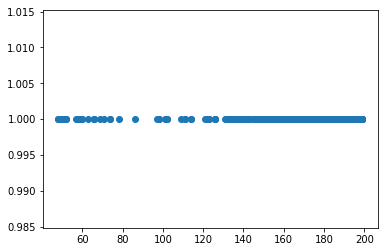

In [13]:
plt.scatter(distribution[:,1],distribution[:,0])

In [14]:
DATA = np.append(SP_F, SH_F, axis = 1)
np.random.shuffle(DATA)

X = DATA[:, :200]
Y = DATA[:,200:]
X = np.subtract(X, 0.5)
#keras.utils.normalize(X)

train_size = int(len(DATA) * 0.8)

train_X = X[0:train_size, :]
train_Y = Y[0:train_size, :]
test_X = X[train_size:, :]
test_Y = Y[train_size:, :]

In [16]:
model = init_model()
history = model.fit(train_X, train_Y, 
                    epochs=1000, 
                    batch_size=20,
                    validation_data=(test_X, test_Y), 
                    verbose=2)

train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Train on 372 samples, validate on 93 samples
Epoch 1/1000
 - 1s - loss: 0.0532 - acc: 0.3145 - val_loss: 0.0171 - val_acc: 0.4194
Epoch 2/1000
 - 0s - loss: 0.0134 - acc: 0.1371 - val_loss: 0.0075 - val_acc: 0.1183
Epoch 3/1000
 - 0s - loss: 0.0042 - acc: 0.1882 - val_loss: 0.0040 - val_acc: 0.4194
Epoch 4/1000
 - 0s - loss: 0.0034 - acc: 0.3172 - val_loss: 0.0039 - val_acc: 0.1505
Epoch 5/1000
 - 0s - loss: 0.0032 - acc: 0.2285 - val_loss: 0.0040 - val_acc: 0.4301
Epoch 6/1000
 - 0s - loss: 0.0032 - acc: 0.2957 - val_loss: 0.0037 - val_acc: 0.4194
Epoch 7/1000
 - 0s - loss: 0.0031 - acc: 0.3441 - val_loss: 0.0038 - val_acc: 0.2151
Epoch 8/1000
 - 0s - loss: 0.0031 - acc: 0.2984 - val_loss: 0.0037 - val_acc: 0.2043
Epoch 9/1000
 - 0s - loss: 0.0032 - acc: 0.3011 - val_loss: 0.0038 - val_acc: 0.1613
Epoch 10/1000
 - 0s - loss: 0.0031 - acc: 0.2554 - val_loss: 0.0036 - val_acc: 0.4194
Epoch 11/1000
 - 0s - loss: 0.0030 - acc: 0.3333 - val_loss: 0.0036 - val_acc: 0.2903
Epoch 12/1000
 - 0

Epoch 96/1000
 - 0s - loss: 0.0020 - acc: 0.3333 - val_loss: 0.0027 - val_acc: 0.4194
Epoch 97/1000
 - 0s - loss: 0.0021 - acc: 0.3629 - val_loss: 0.0026 - val_acc: 0.3656
Epoch 98/1000
 - 0s - loss: 0.0021 - acc: 0.3522 - val_loss: 0.0028 - val_acc: 0.2796
Epoch 99/1000
 - 0s - loss: 0.0020 - acc: 0.3871 - val_loss: 0.0027 - val_acc: 0.3011
Epoch 100/1000
 - 0s - loss: 0.0021 - acc: 0.3118 - val_loss: 0.0025 - val_acc: 0.4624
Epoch 101/1000
 - 0s - loss: 0.0020 - acc: 0.3817 - val_loss: 0.0025 - val_acc: 0.4194
Epoch 102/1000
 - 0s - loss: 0.0020 - acc: 0.3387 - val_loss: 0.0027 - val_acc: 0.3978
Epoch 103/1000
 - 0s - loss: 0.0020 - acc: 0.3495 - val_loss: 0.0025 - val_acc: 0.3333
Epoch 104/1000
 - 0s - loss: 0.0021 - acc: 0.3172 - val_loss: 0.0027 - val_acc: 0.3226
Epoch 105/1000
 - 0s - loss: 0.0021 - acc: 0.3522 - val_loss: 0.0027 - val_acc: 0.2688
Epoch 106/1000
 - 0s - loss: 0.0022 - acc: 0.3011 - val_loss: 0.0026 - val_acc: 0.3763
Epoch 107/1000
 - 0s - loss: 0.0021 - acc: 0.37

Epoch 191/1000
 - 0s - loss: 0.0017 - acc: 0.3952 - val_loss: 0.0024 - val_acc: 0.3226
Epoch 192/1000
 - 0s - loss: 0.0017 - acc: 0.3710 - val_loss: 0.0026 - val_acc: 0.3118
Epoch 193/1000
 - 0s - loss: 0.0017 - acc: 0.3656 - val_loss: 0.0025 - val_acc: 0.3226
Epoch 194/1000
 - 0s - loss: 0.0017 - acc: 0.3952 - val_loss: 0.0024 - val_acc: 0.3548
Epoch 195/1000
 - 0s - loss: 0.0017 - acc: 0.3710 - val_loss: 0.0028 - val_acc: 0.2258
Epoch 196/1000
 - 0s - loss: 0.0018 - acc: 0.3844 - val_loss: 0.0027 - val_acc: 0.2581
Epoch 197/1000
 - 0s - loss: 0.0018 - acc: 0.3495 - val_loss: 0.0024 - val_acc: 0.3441
Epoch 198/1000
 - 0s - loss: 0.0017 - acc: 0.3468 - val_loss: 0.0024 - val_acc: 0.4731
Epoch 199/1000
 - 0s - loss: 0.0018 - acc: 0.3844 - val_loss: 0.0024 - val_acc: 0.3871
Epoch 200/1000
 - 0s - loss: 0.0018 - acc: 0.3522 - val_loss: 0.0024 - val_acc: 0.2796
Epoch 201/1000
 - 0s - loss: 0.0018 - acc: 0.3441 - val_loss: 0.0028 - val_acc: 0.3118
Epoch 202/1000
 - 0s - loss: 0.0018 - acc: 

Epoch 286/1000
 - 0s - loss: 0.0015 - acc: 0.3763 - val_loss: 0.0022 - val_acc: 0.3656
Epoch 287/1000
 - 0s - loss: 0.0015 - acc: 0.4167 - val_loss: 0.0024 - val_acc: 0.3763
Epoch 288/1000
 - 0s - loss: 0.0014 - acc: 0.4435 - val_loss: 0.0024 - val_acc: 0.3763
Epoch 289/1000
 - 0s - loss: 0.0016 - acc: 0.3817 - val_loss: 0.0028 - val_acc: 0.3226
Epoch 290/1000
 - 0s - loss: 0.0015 - acc: 0.4194 - val_loss: 0.0024 - val_acc: 0.3656
Epoch 291/1000
 - 0s - loss: 0.0015 - acc: 0.3844 - val_loss: 0.0024 - val_acc: 0.4194
Epoch 292/1000
 - 0s - loss: 0.0014 - acc: 0.3952 - val_loss: 0.0024 - val_acc: 0.4086
Epoch 293/1000
 - 0s - loss: 0.0015 - acc: 0.4409 - val_loss: 0.0024 - val_acc: 0.3441
Epoch 294/1000
 - 0s - loss: 0.0014 - acc: 0.4113 - val_loss: 0.0023 - val_acc: 0.3333
Epoch 295/1000
 - 0s - loss: 0.0013 - acc: 0.4167 - val_loss: 0.0023 - val_acc: 0.3656
Epoch 296/1000
 - 0s - loss: 0.0015 - acc: 0.4140 - val_loss: 0.0024 - val_acc: 0.3978
Epoch 297/1000
 - 0s - loss: 0.0015 - acc: 

Epoch 381/1000
 - 0s - loss: 0.0012 - acc: 0.4274 - val_loss: 0.0024 - val_acc: 0.3226
Epoch 382/1000
 - 0s - loss: 0.0013 - acc: 0.4113 - val_loss: 0.0022 - val_acc: 0.3441
Epoch 383/1000
 - 0s - loss: 0.0014 - acc: 0.4543 - val_loss: 0.0027 - val_acc: 0.3763
Epoch 384/1000
 - 0s - loss: 0.0014 - acc: 0.4274 - val_loss: 0.0022 - val_acc: 0.4194
Epoch 385/1000
 - 0s - loss: 0.0013 - acc: 0.4570 - val_loss: 0.0023 - val_acc: 0.2581
Epoch 386/1000
 - 0s - loss: 0.0012 - acc: 0.4570 - val_loss: 0.0023 - val_acc: 0.3011
Epoch 387/1000
 - 0s - loss: 0.0011 - acc: 0.4597 - val_loss: 0.0024 - val_acc: 0.3656
Epoch 388/1000
 - 0s - loss: 0.0011 - acc: 0.4247 - val_loss: 0.0023 - val_acc: 0.3548
Epoch 389/1000
 - 0s - loss: 0.0012 - acc: 0.4355 - val_loss: 0.0025 - val_acc: 0.3871
Epoch 390/1000
 - 0s - loss: 0.0011 - acc: 0.4785 - val_loss: 0.0023 - val_acc: 0.3871
Epoch 391/1000
 - 0s - loss: 0.0011 - acc: 0.4812 - val_loss: 0.0023 - val_acc: 0.3226
Epoch 392/1000
 - 0s - loss: 0.0012 - acc: 

Epoch 475/1000
 - 0s - loss: 9.4455e-04 - acc: 0.4839 - val_loss: 0.0022 - val_acc: 0.3871
Epoch 476/1000
 - 0s - loss: 0.0010 - acc: 0.4785 - val_loss: 0.0024 - val_acc: 0.3763
Epoch 477/1000
 - 0s - loss: 0.0011 - acc: 0.4677 - val_loss: 0.0023 - val_acc: 0.3226
Epoch 478/1000
 - 0s - loss: 9.3616e-04 - acc: 0.4731 - val_loss: 0.0024 - val_acc: 0.3333
Epoch 479/1000
 - 0s - loss: 9.9003e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.4086
Epoch 480/1000
 - 0s - loss: 9.6019e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.3548
Epoch 481/1000
 - 0s - loss: 0.0010 - acc: 0.4919 - val_loss: 0.0021 - val_acc: 0.3978
Epoch 482/1000
 - 0s - loss: 8.8268e-04 - acc: 0.5054 - val_loss: 0.0023 - val_acc: 0.4301
Epoch 483/1000
 - 0s - loss: 9.0029e-04 - acc: 0.5215 - val_loss: 0.0023 - val_acc: 0.4946
Epoch 484/1000
 - 0s - loss: 9.7109e-04 - acc: 0.5027 - val_loss: 0.0023 - val_acc: 0.4624
Epoch 485/1000
 - 0s - loss: 9.9588e-04 - acc: 0.4839 - val_loss: 0.0022 - val_acc: 0.3333
Epoch 486/1

Epoch 566/1000
 - 0s - loss: 7.2752e-04 - acc: 0.5054 - val_loss: 0.0023 - val_acc: 0.4301
Epoch 567/1000
 - 0s - loss: 7.5737e-04 - acc: 0.4946 - val_loss: 0.0022 - val_acc: 0.3763
Epoch 568/1000
 - 0s - loss: 8.1204e-04 - acc: 0.5376 - val_loss: 0.0023 - val_acc: 0.4194
Epoch 569/1000
 - 0s - loss: 8.8873e-04 - acc: 0.4677 - val_loss: 0.0025 - val_acc: 0.3548
Epoch 570/1000
 - 0s - loss: 9.9988e-04 - acc: 0.4409 - val_loss: 0.0024 - val_acc: 0.3441
Epoch 571/1000
 - 0s - loss: 0.0011 - acc: 0.5188 - val_loss: 0.0024 - val_acc: 0.3011
Epoch 572/1000
 - 0s - loss: 0.0011 - acc: 0.4597 - val_loss: 0.0023 - val_acc: 0.3226
Epoch 573/1000
 - 0s - loss: 0.0011 - acc: 0.4839 - val_loss: 0.0027 - val_acc: 0.3226
Epoch 574/1000
 - 0s - loss: 0.0011 - acc: 0.4597 - val_loss: 0.0022 - val_acc: 0.3871
Epoch 575/1000
 - 0s - loss: 9.1553e-04 - acc: 0.5054 - val_loss: 0.0024 - val_acc: 0.4301
Epoch 576/1000
 - 0s - loss: 8.1439e-04 - acc: 0.4866 - val_loss: 0.0022 - val_acc: 0.3548
Epoch 577/1000


Epoch 657/1000
 - 0s - loss: 5.9264e-04 - acc: 0.5027 - val_loss: 0.0022 - val_acc: 0.3333
Epoch 658/1000
 - 0s - loss: 6.3985e-04 - acc: 0.5565 - val_loss: 0.0022 - val_acc: 0.3333
Epoch 659/1000
 - 0s - loss: 7.2630e-04 - acc: 0.5484 - val_loss: 0.0023 - val_acc: 0.4839
Epoch 660/1000
 - 0s - loss: 9.8208e-04 - acc: 0.4785 - val_loss: 0.0023 - val_acc: 0.3333
Epoch 661/1000
 - 0s - loss: 8.1290e-04 - acc: 0.4543 - val_loss: 0.0022 - val_acc: 0.3978
Epoch 662/1000
 - 0s - loss: 9.4166e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.4624
Epoch 663/1000
 - 0s - loss: 7.9127e-04 - acc: 0.5269 - val_loss: 0.0022 - val_acc: 0.3656
Epoch 664/1000
 - 0s - loss: 7.6180e-04 - acc: 0.4973 - val_loss: 0.0023 - val_acc: 0.4624
Epoch 665/1000
 - 0s - loss: 6.8184e-04 - acc: 0.5376 - val_loss: 0.0023 - val_acc: 0.3548
Epoch 666/1000
 - 0s - loss: 8.0540e-04 - acc: 0.4812 - val_loss: 0.0023 - val_acc: 0.3441
Epoch 667/1000
 - 0s - loss: 6.4982e-04 - acc: 0.5511 - val_loss: 0.0021 - val_acc: 0.4086

Epoch 748/1000
 - 0s - loss: 0.0011 - acc: 0.4597 - val_loss: 0.0025 - val_acc: 0.3763
Epoch 749/1000
 - 0s - loss: 0.0012 - acc: 0.4758 - val_loss: 0.0025 - val_acc: 0.3118
Epoch 750/1000
 - 0s - loss: 0.0010 - acc: 0.4677 - val_loss: 0.0023 - val_acc: 0.4194
Epoch 751/1000
 - 0s - loss: 8.3260e-04 - acc: 0.5349 - val_loss: 0.0023 - val_acc: 0.4086
Epoch 752/1000
 - 0s - loss: 7.1060e-04 - acc: 0.5134 - val_loss: 0.0022 - val_acc: 0.3548
Epoch 753/1000
 - 0s - loss: 6.3012e-04 - acc: 0.5349 - val_loss: 0.0022 - val_acc: 0.3333
Epoch 754/1000
 - 0s - loss: 6.1689e-04 - acc: 0.5188 - val_loss: 0.0022 - val_acc: 0.3763
Epoch 755/1000
 - 0s - loss: 5.8419e-04 - acc: 0.5457 - val_loss: 0.0021 - val_acc: 0.3871
Epoch 756/1000
 - 0s - loss: 5.3656e-04 - acc: 0.5538 - val_loss: 0.0022 - val_acc: 0.3978
Epoch 757/1000
 - 0s - loss: 5.9238e-04 - acc: 0.5323 - val_loss: 0.0023 - val_acc: 0.4731
Epoch 758/1000
 - 0s - loss: 5.9089e-04 - acc: 0.5188 - val_loss: 0.0022 - val_acc: 0.3118
Epoch 759/1

 - 0s - loss: 6.2755e-04 - acc: 0.5242 - val_loss: 0.0023 - val_acc: 0.4301
Epoch 839/1000
 - 0s - loss: 5.5506e-04 - acc: 0.5269 - val_loss: 0.0021 - val_acc: 0.4194
Epoch 840/1000
 - 0s - loss: 5.3325e-04 - acc: 0.5887 - val_loss: 0.0024 - val_acc: 0.3656
Epoch 841/1000
 - 0s - loss: 6.1602e-04 - acc: 0.5403 - val_loss: 0.0023 - val_acc: 0.3763
Epoch 842/1000
 - 0s - loss: 6.3864e-04 - acc: 0.5054 - val_loss: 0.0022 - val_acc: 0.4194
Epoch 843/1000
 - 0s - loss: 5.3959e-04 - acc: 0.5323 - val_loss: 0.0022 - val_acc: 0.3656
Epoch 844/1000
 - 0s - loss: 5.5303e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.3441
Epoch 845/1000
 - 0s - loss: 5.4235e-04 - acc: 0.5484 - val_loss: 0.0022 - val_acc: 0.4409
Epoch 846/1000
 - 0s - loss: 4.9492e-04 - acc: 0.5941 - val_loss: 0.0023 - val_acc: 0.3871
Epoch 847/1000
 - 0s - loss: 4.7304e-04 - acc: 0.5538 - val_loss: 0.0022 - val_acc: 0.3548
Epoch 848/1000
 - 0s - loss: 5.4510e-04 - acc: 0.5134 - val_loss: 0.0021 - val_acc: 0.4086
Epoch 849/1000

Epoch 929/1000
 - 0s - loss: 6.2488e-04 - acc: 0.5323 - val_loss: 0.0024 - val_acc: 0.4301
Epoch 930/1000
 - 0s - loss: 6.2057e-04 - acc: 0.5457 - val_loss: 0.0024 - val_acc: 0.4086
Epoch 931/1000
 - 0s - loss: 6.3625e-04 - acc: 0.5726 - val_loss: 0.0023 - val_acc: 0.3871
Epoch 932/1000
 - 0s - loss: 5.8820e-04 - acc: 0.5242 - val_loss: 0.0021 - val_acc: 0.4516
Epoch 933/1000
 - 0s - loss: 6.6757e-04 - acc: 0.5000 - val_loss: 0.0023 - val_acc: 0.4086
Epoch 934/1000
 - 0s - loss: 5.8670e-04 - acc: 0.5323 - val_loss: 0.0024 - val_acc: 0.4194
Epoch 935/1000
 - 0s - loss: 6.6128e-04 - acc: 0.5457 - val_loss: 0.0022 - val_acc: 0.3871
Epoch 936/1000
 - 0s - loss: 5.2725e-04 - acc: 0.5349 - val_loss: 0.0022 - val_acc: 0.4731
Epoch 937/1000
 - 0s - loss: 5.6245e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.4301
Epoch 938/1000
 - 0s - loss: 6.7813e-04 - acc: 0.5511 - val_loss: 0.0023 - val_acc: 0.3978
Epoch 939/1000
 - 0s - loss: 5.0762e-04 - acc: 0.5161 - val_loss: 0.0023 - val_acc: 0.3441

NameError: name 'tandem' is not defined

93/93 [==============================] - 0s 53us/step
[0.0004604287548503909, 0.5349462410455109]
[0.0020247585370495756, 0.43010753585446265]


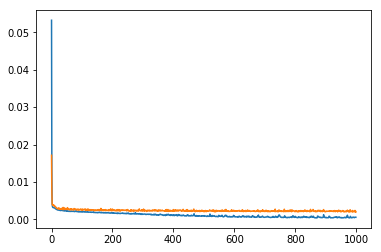

In [17]:
train_score = model.evaluate(train_X, train_Y, batch_size=20)
test_score = model.evaluate(test_X, test_Y, batch_size= 50)
print(train_score)
print(test_score)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

Test 0
True shape: [0.1        0.13169178 0.2        0.2        0.2370452  0.3       ]
Predicted shape: [[0.12217113 0.17566204 0.12620139 0.20970038 0.2957347  0.32381618]]



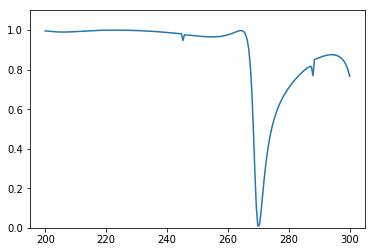

Test 1
True shape: [0.19753767 0.2        0.2        0.2        0.19753767 0.2       ]
Predicted shape: [[0.20701107 0.19669268 0.1917519  0.19848886 0.20809352 0.20332466]]



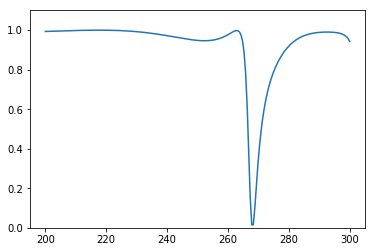

Test 2
True shape: [0.2        0.3        0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.26617867 0.2673466  0.19143152 0.11742148 0.17316924 0.10440897]]



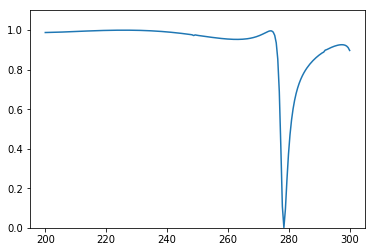

Test 3
True shape: [0.2        0.13169178 0.1        0.2        0.2370452  0.3       ]
Predicted shape: [[0.2710782  0.22791114 0.21213835 0.1409609  0.12369569 0.17378637]]



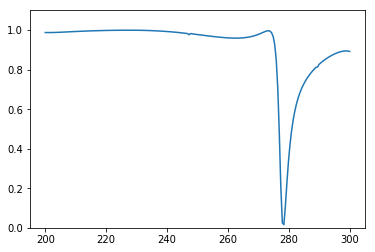

Test 4
True shape: [0.19753767 0.2        0.3        0.2        0.1        0.1       ]
Predicted shape: [[0.24692222 0.19063139 0.24574444 0.20241484 0.1281594  0.12462591]]



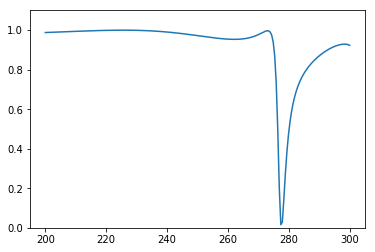

Test 5
True shape: [0.09876883 0.1        0.13169178 0.2        0.3        0.2963065 ]
Predicted shape: [[0.06425053 0.07707888 0.15710208 0.22385162 0.2692031  0.31148475]]



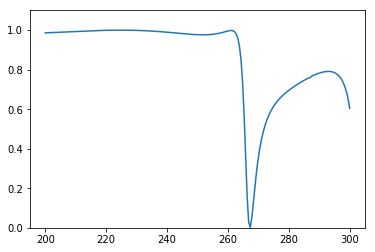

Test 6
True shape: [0.2 0.2 0.1 0.2 0.2 0.2]
Predicted shape: [[0.261535   0.18051869 0.11263964 0.14791599 0.22445868 0.20844257]]



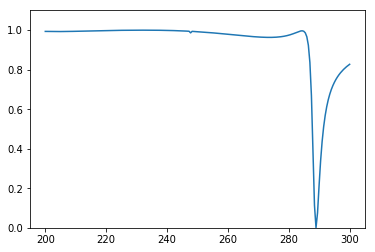

Test 7
True shape: [0.2 0.2 0.2 0.1 0.2 0.3]
Predicted shape: [[0.2169089  0.1954861  0.17538583 0.12575942 0.1988903  0.27742812]]



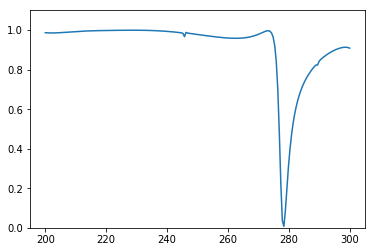

Test 8
True shape: [0.2        0.2        0.19753767 0.2        0.1        0.1       ]
Predicted shape: [[0.19157442 0.19334656 0.2014701  0.20011818 0.10639181 0.09657783]]



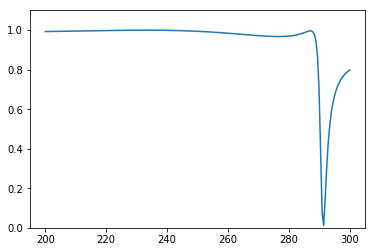

Test 9
True shape: [0.2        0.19753767 0.2        0.1        0.2        0.2       ]
Predicted shape: [[0.21829247 0.19019964 0.2038444  0.095604   0.20046784 0.20045808]]



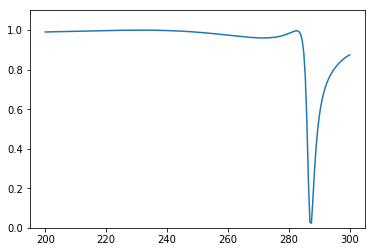

Test 10
True shape: [0.3        0.2        0.1        0.13169178 0.2        0.19753767]
Predicted shape: [[0.16723481 0.14566574 0.14440012 0.19491178 0.20516244 0.1935225 ]]



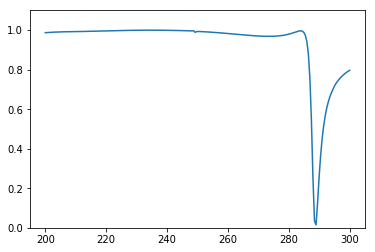

Test 11
True shape: [0.2        0.3        0.2        0.13169178 0.1        0.09876883]
Predicted shape: [[0.23522419 0.27945125 0.19900584 0.14052197 0.10162511 0.11261988]]



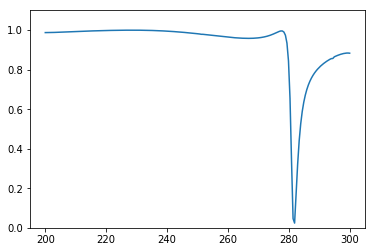

Test 12
True shape: [0.09510565 0.09629116 0.1        0.2        0.2370452  0.3       ]
Predicted shape: [[0.09428936 0.0962888  0.10961965 0.19883063 0.22875713 0.29031986]]



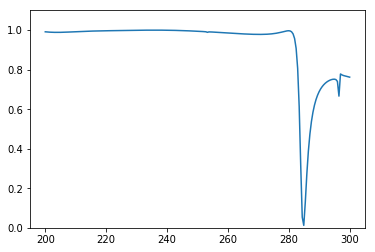

Test 13
True shape: [0.3        0.2        0.1        0.11723925 0.14600443 0.2       ]
Predicted shape: [[0.21909326 0.19350353 0.193934   0.18757313 0.09682975 0.07626938]]



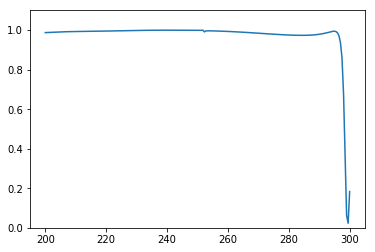

Test 14
True shape: [0.3 0.2 0.1 0.2 0.1 0.2]
Predicted shape: [[0.2068471  0.19766346 0.17182815 0.13545069 0.14556092 0.15494671]]



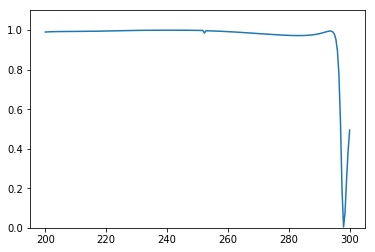

Test 15
True shape: [0.09510565 0.09629116 0.1        0.2        0.3        0.2       ]
Predicted shape: [[0.08915874 0.19077161 0.17667282 0.1911551  0.19094446 0.11955836]]



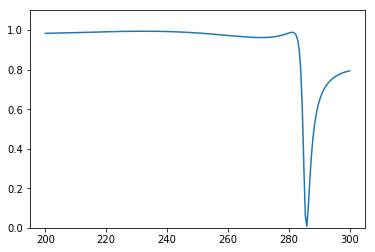

Test 16
True shape: [0.2 0.1 0.2 0.2 0.3 0.2]
Predicted shape: [[0.19365516 0.18154019 0.18587601 0.20272604 0.21093479 0.24012172]]



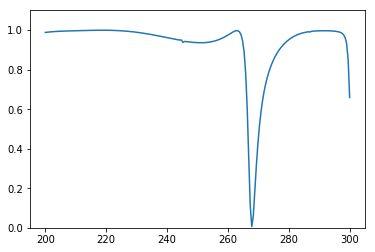

Test 17
True shape: [0.1 0.2 0.1 0.2 0.3 0.2]
Predicted shape: [[0.1729683  0.19117466 0.18663514 0.18944734 0.1938762  0.10391804]]



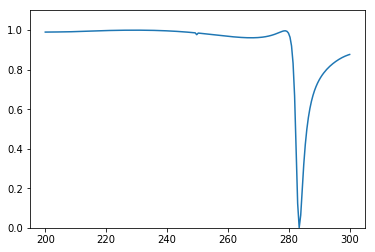

Test 18
True shape: [0.2        0.2        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.20429924 0.19638604 0.19392315 0.19818997 0.20631574 0.20462842]]



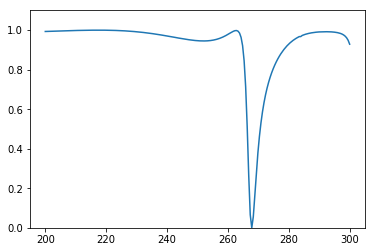

Test 19
True shape: [0.1902113  0.19258231 0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.20564836 0.19443333 0.19409981 0.19590136 0.20370992 0.1967982 ]]



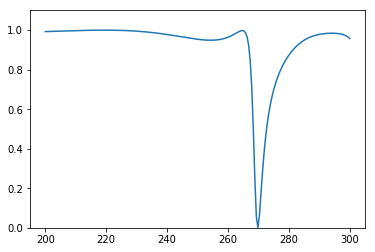

Test 20
True shape: [0.3        0.2        0.19753767 0.2        0.13169178 0.1       ]
Predicted shape: [[0.15771532 0.18062907 0.23662484 0.21533954 0.19115257 0.1057093 ]]



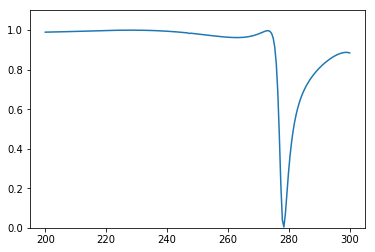

Test 21
True shape: [0.2        0.2        0.2        0.14600443 0.11723925 0.1       ]
Predicted shape: [[0.15792641 0.18320543 0.20117605 0.1538563  0.11711756 0.13541208]]



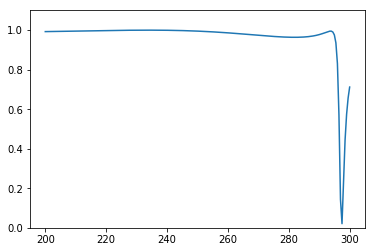

Test 22
True shape: [0.3       0.2370452 0.2       0.2       0.1       0.1      ]
Predicted shape: [[0.19657522 0.1835357  0.14467889 0.19770873 0.26498577 0.20785502]]



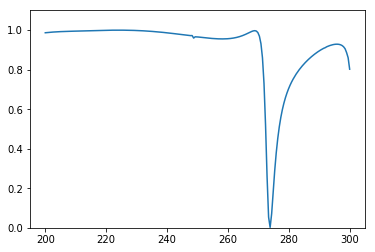

Test 23
True shape: [0.1        0.1        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.10177088 0.09475866 0.20763716 0.19315645 0.20656447 0.19026512]]



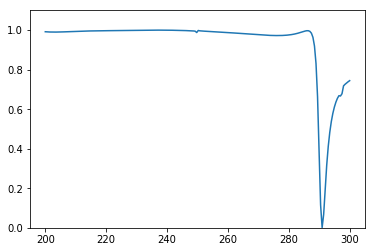

Test 24
True shape: [0.3        0.2        0.1        0.1        0.2        0.19753767]
Predicted shape: [[0.24104258 0.1594438  0.16655695 0.1446251  0.14363666 0.19938408]]



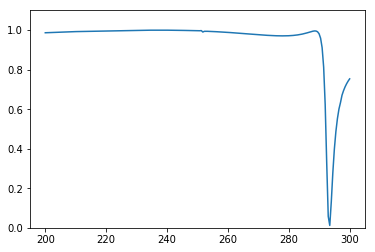

Test 25
True shape: [0.4        0.3        0.2        0.1        0.2        0.19753767]
Predicted shape: [[0.41446507 0.30854332 0.19031051 0.11030799 0.18761334 0.18493181]]



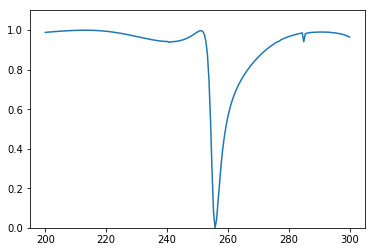

Test 26
True shape: [0.4        0.3        0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.4074419  0.29343224 0.21319476 0.11722508 0.11169603 0.21321526]]



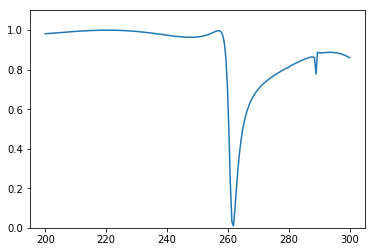

Test 27
True shape: [0.19753767 0.2        0.1        0.2        0.19753767 0.2       ]
Predicted shape: [[0.2086254  0.19953334 0.15251815 0.20786715 0.14823903 0.1438291 ]]



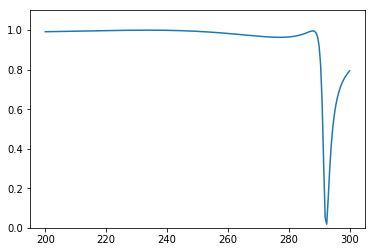

Test 28
True shape: [0.1        0.13169178 0.2        0.19753767 0.2        0.19753767]
Predicted shape: [[0.11757052 0.11648101 0.2045995  0.20683104 0.2059353  0.18680549]]



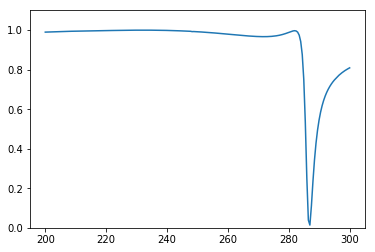

Test 29
True shape: [0.2        0.2        0.19753767 0.2        0.2        0.19753767]
Predicted shape: [[0.20615277 0.19676083 0.19245291 0.19829583 0.20805137 0.20379575]]



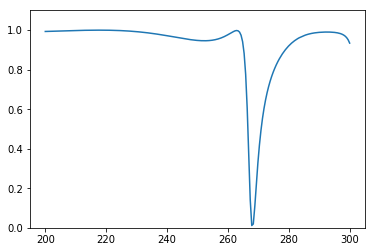

Test 30
True shape: [0.3        0.2        0.13169178 0.1        0.2        0.2       ]
Predicted shape: [[0.21839833 0.1973435  0.146918   0.0999057  0.19825292 0.27179793]]



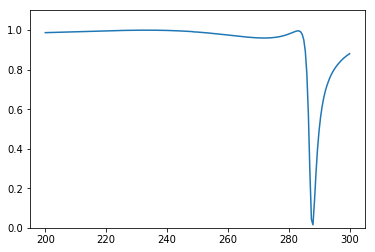

Test 31
True shape: [0.19753767 0.2        0.1815962  0.17013016 0.1638203  0.1618034 ]
Predicted shape: [[0.21592617 0.18839791 0.16672105 0.16948411 0.16944487 0.15434416]]



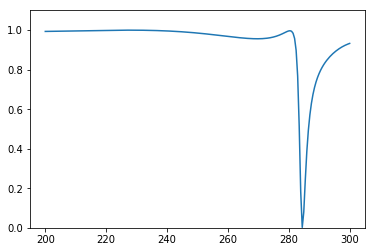

Test 32
True shape: [0.2        0.19753767 0.2        0.2        0.13169178 0.1       ]
Predicted shape: [[0.21858943 0.19824702 0.200037   0.18778813 0.13146177 0.09751152]]



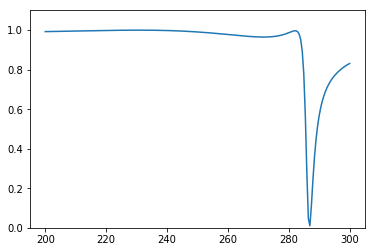

Test 33
True shape: [0.1        0.2        0.19507534 0.19507534 0.2        0.1       ]
Predicted shape: [[0.19847792 0.19155583 0.18897066 0.12847844 0.15724176 0.22565687]]



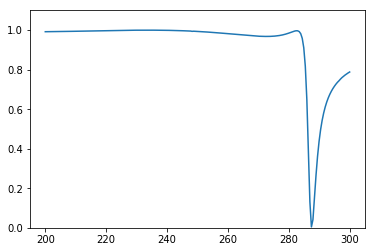

Test 34
True shape: [0.1        0.11723925 0.14600443 0.2        0.3        0.2       ]
Predicted shape: [[0.11787832 0.20952371 0.20275119 0.21960583 0.21175092 0.2156423 ]]



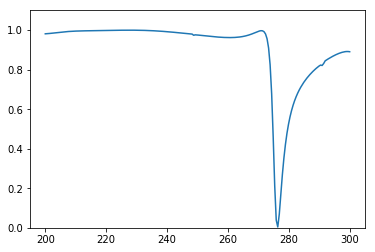

Test 35
True shape: [0.1 0.1 0.1 0.2 0.3 0.3]
Predicted shape: [[0.12269387 0.10931841 0.12705517 0.21764588 0.31212267 0.31255573]]



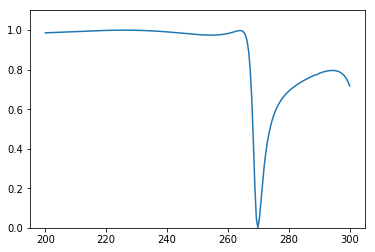

Test 36
True shape: [0.1 0.1 0.2 0.3 0.2 0.2]
Predicted shape: [[0.11734155 0.10302016 0.19881374 0.29239917 0.21029253 0.20043242]]



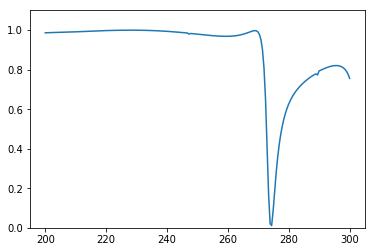

Test 37
True shape: [0.3        0.2370452  0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.19816497 0.18118933 0.14196172 0.19800636 0.26989698 0.20785543]]



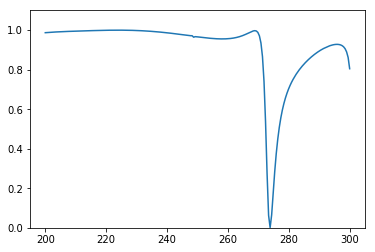

Test 38
True shape: [0.3       0.2370452 0.2       0.1       0.2       0.1      ]
Predicted shape: [[0.35016418 0.17468062 0.14906505 0.1062223  0.15361895 0.17932552]]



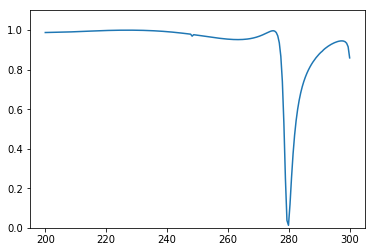

Test 39
True shape: [0.1        0.11723925 0.14600443 0.2        0.2        0.19753767]
Predicted shape: [[0.09527424 0.10489109 0.14488184 0.20666537 0.21715136 0.20000756]]



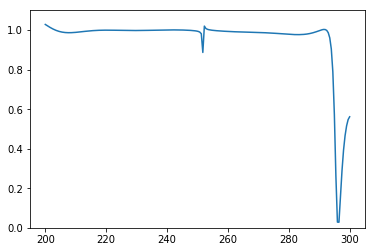

Test 40
True shape: [0.1782013  0.18042261 0.18737194 0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.22597122 0.19508082 0.13999149 0.19255188 0.22022143 0.23045626]]



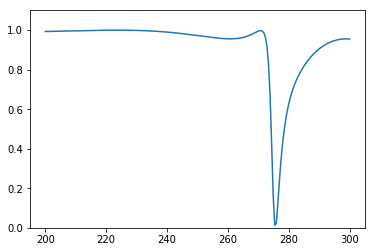

Test 41
True shape: [0.1        0.1        0.2        0.19507534 0.19507534 0.2       ]
Predicted shape: [[0.09447888 0.11706531 0.20440045 0.19259033 0.18248557 0.19341245]]



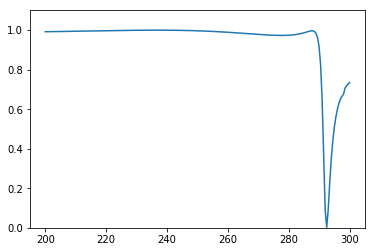

Test 42
True shape: [0.3        0.2        0.19753767 0.2        0.1        0.2       ]
Predicted shape: [[0.24598601 0.19717559 0.21935347 0.20952192 0.15222472 0.09279756]]



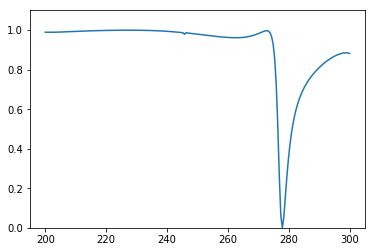

Test 43
True shape: [0.4        0.3        0.2370452  0.2        0.13169178 0.1       ]
Predicted shape: [[0.40648544 0.29196957 0.23835137 0.2143254  0.10397194 0.2069201 ]]



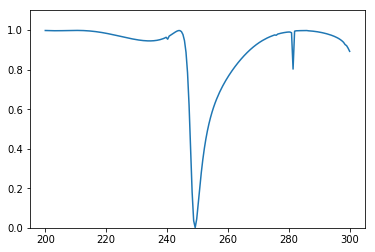

Test 44
True shape: [0.09876883 0.1        0.13169178 0.2        0.2        0.3       ]
Predicted shape: [[0.11922666 0.11672536 0.14908156 0.19847152 0.21145761 0.23297563]]



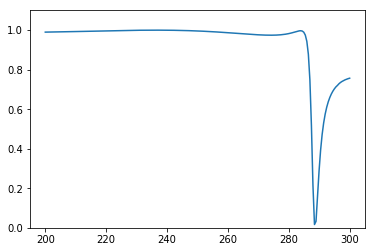

Test 45
True shape: [0.19753767 0.2        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.19362399 0.1993005  0.19908634 0.18814695 0.18524672 0.09838981]]



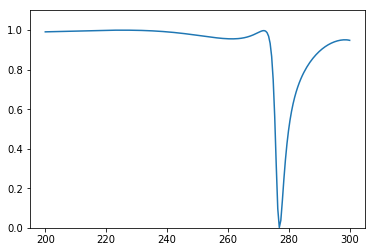

Test 46
True shape: [0.1902113  0.19258231 0.2        0.2        0.13169178 0.1       ]
Predicted shape: [[0.19902626 0.1553083  0.13307068 0.18523028 0.20234925 0.19045158]]



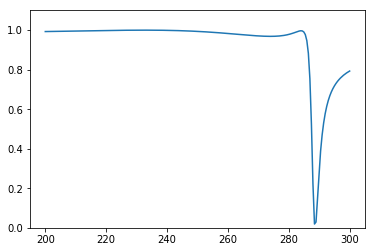

Test 47
True shape: [0.2        0.2        0.1        0.2        0.19753767 0.2       ]
Predicted shape: [[0.12517855 0.13022444 0.14395478 0.20961103 0.18967046 0.2711811 ]]



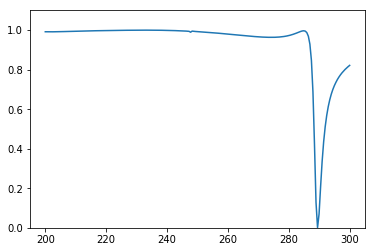

Test 48
True shape: [0.2 0.1 0.1 0.2 0.2 0.3]
Predicted shape: [[0.22479782 0.20988804 0.16539976 0.12951139 0.14537488 0.17745371]]



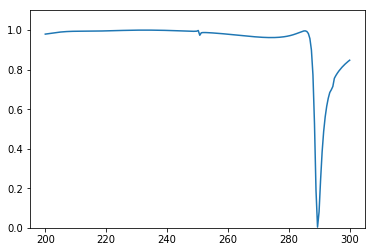

Test 49
True shape: [0.2        0.1        0.2        0.18737194 0.18042261 0.1782013 ]
Predicted shape: [[0.22032025 0.11995065 0.17400983 0.19267085 0.19644916 0.08750517]]



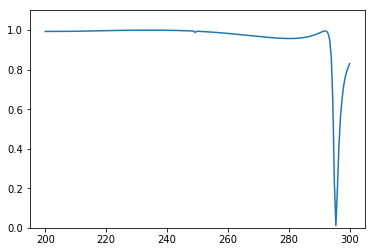

Test 50
True shape: [0.4        0.3        0.2        0.1        0.1        0.09876883]
Predicted shape: [[0.40156174 0.2986338  0.19839409 0.10334125 0.10793537 0.09936961]]



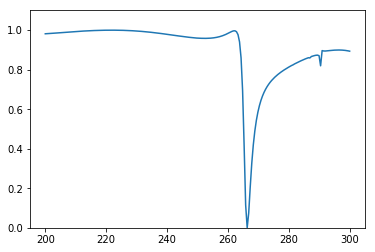

Test 51
True shape: [0.2 0.2 0.1 0.1 0.2 0.3]
Predicted shape: [[0.1488643  0.13407457 0.14546502 0.19396672 0.20088553 0.19041224]]



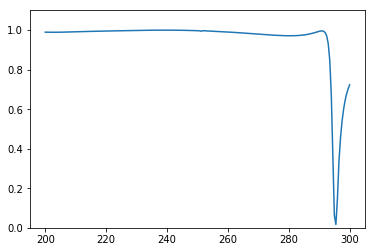

Test 52
True shape: [0.2        0.1        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.19120741 0.10955441 0.2167128  0.18005672 0.17869638 0.2029283 ]]



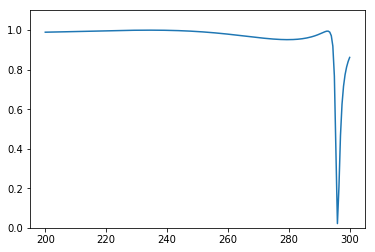

Test 53
True shape: [0.2        0.19507534 0.19507534 0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.20526513 0.19307026 0.19455388 0.19360274 0.20402846 0.1998531 ]]



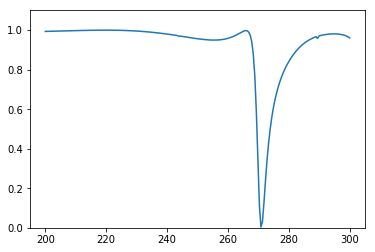

Test 54
True shape: [0.2 0.1 0.2 0.2 0.2 0.3]
Predicted shape: [[0.20228958 0.12779313 0.19312605 0.1949527  0.21347779 0.2936501 ]]



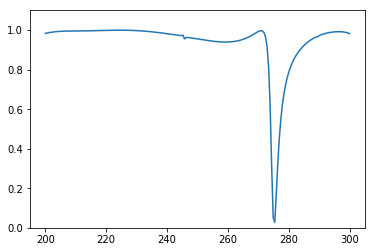

Test 55
True shape: [0.2        0.2        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.1975295  0.20510492 0.20191094 0.1917654  0.19066697 0.10465363]]



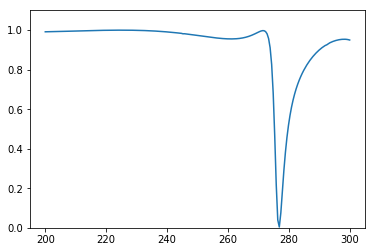

Test 56
True shape: [0.2       0.3       0.2963065 0.3       0.3       0.2      ]
Predicted shape: [[0.30232832 0.29570624 0.29942632 0.19961643 0.3002607  0.29632616]]



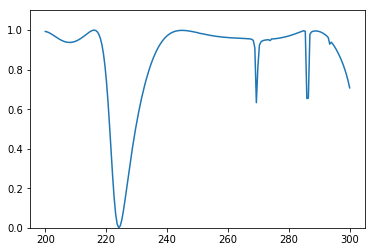

Test 57
True shape: [0.09876883 0.1        0.2        0.2        0.19753767 0.2       ]
Predicted shape: [[0.10113019 0.089398   0.20160225 0.20121235 0.2059925  0.18823577]]



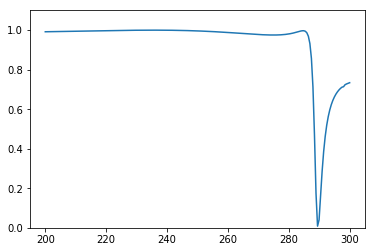

Test 58
True shape: [0.3        0.2        0.1815962  0.17013016 0.1638203  0.1618034 ]
Predicted shape: [[0.21397883 0.15410733 0.2079123  0.18971288 0.19631249 0.24867915]]



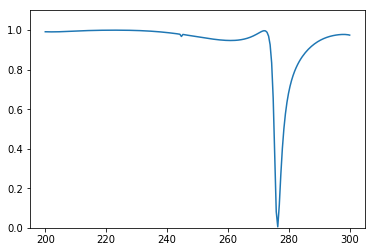

Test 59
True shape: [0.1        0.2        0.19753767 0.2        0.19258231 0.1902113 ]
Predicted shape: [[0.11772305 0.1864205  0.19959104 0.21093792 0.21185735 0.14241016]]



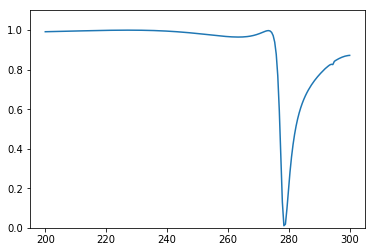

Test 60
True shape: [0.1902113  0.19258231 0.2        0.1        0.13169178 0.2       ]
Predicted shape: [[0.16967162 0.13098872 0.14523241 0.18212476 0.20572    0.14682579]]



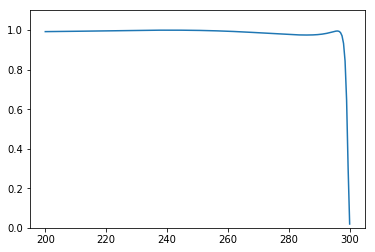

Test 61
True shape: [0.19753767 0.2        0.2        0.19753767 0.2        0.2       ]
Predicted shape: [[0.20628533 0.19645599 0.19265091 0.19824058 0.20758069 0.20377806]]



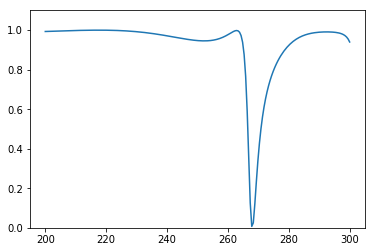

Test 62
True shape: [0.4        0.3        0.2        0.1        0.09876883 0.1       ]
Predicted shape: [[0.40251076 0.3015418  0.19962117 0.10163045 0.09974408 0.09335086]]



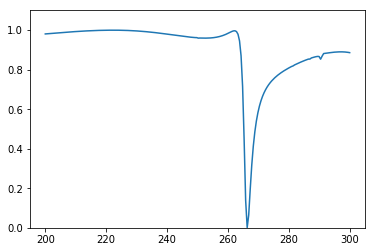

Test 63
True shape: [0.19753767 0.2        0.1        0.2        0.2        0.19753767]
Predicted shape: [[0.20839581 0.1942668  0.13909417 0.20038489 0.17855753 0.16488872]]



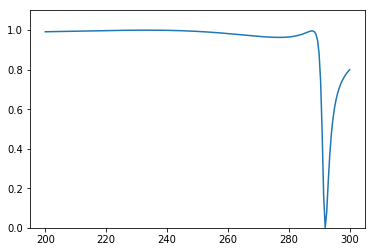

Test 64
True shape: [0.1        0.2        0.19753767 0.2        0.1        0.1       ]
Predicted shape: [[0.18520287 0.18998235 0.18346804 0.14416134 0.14782846 0.14940608]]



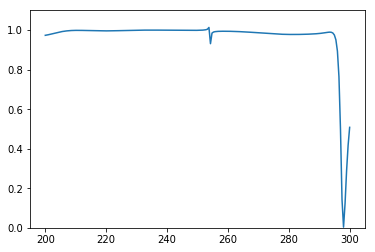

Test 65
True shape: [0.1        0.2        0.2        0.19753767 0.2        0.3       ]
Predicted shape: [[0.10306758 0.1988965  0.19477507 0.19435892 0.2027542  0.30366302]]



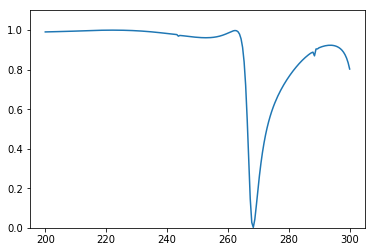

Test 66
True shape: [0.1        0.2        0.19753767 0.2        0.2        0.1       ]
Predicted shape: [[0.10511571 0.11290187 0.22896165 0.19696414 0.19565772 0.21150585]]



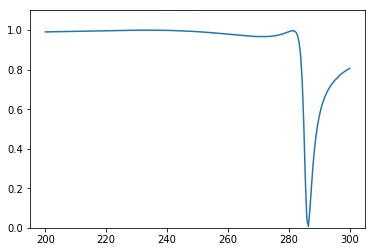

Test 67
True shape: [0.09876883 0.1        0.1        0.2        0.3        0.2963065 ]
Predicted shape: [[0.12030748 0.11999074 0.12216061 0.21524772 0.3109989  0.31279194]]



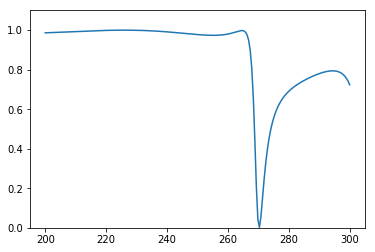

Test 68
True shape: [0.1        0.09876883 0.1        0.2        0.3        0.2       ]
Predicted shape: [[0.10861191 0.11618432 0.11687648 0.19142151 0.29790384 0.20168571]]



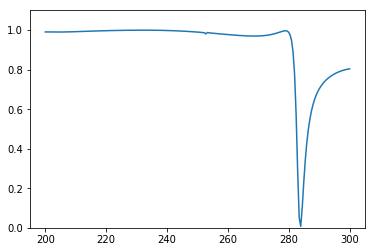

Test 69
True shape: [0.19753767 0.2        0.2        0.1        0.2        0.1       ]
Predicted shape: [[0.19115925 0.19530752 0.19917884 0.14500469 0.17258279 0.10516036]]



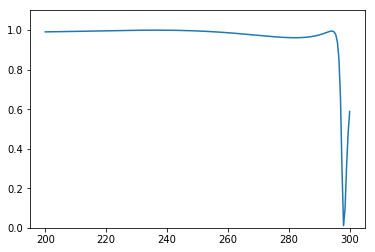

Test 70
True shape: [0.1        0.1        0.13169178 0.2        0.3        0.3       ]
Predicted shape: [[0.12686995 0.10534841 0.14425865 0.21219784 0.29442278 0.2910414 ]]



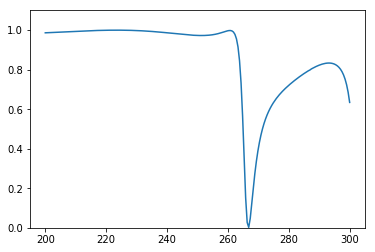

Test 71
True shape: [0.2        0.13169178 0.1        0.13169178 0.2        0.3       ]
Predicted shape: [[0.1507538  0.18189093 0.19849667 0.16051903 0.13846976 0.14495876]]



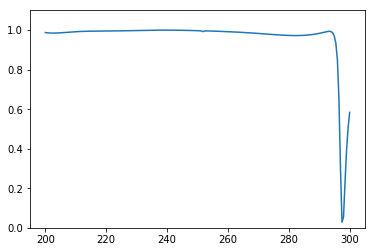

Test 72
True shape: [0.19753767 0.2        0.2        0.2        0.1        0.09876883]
Predicted shape: [[0.20903587 0.19925225 0.21047431 0.20180944 0.08884623 0.08303357]]



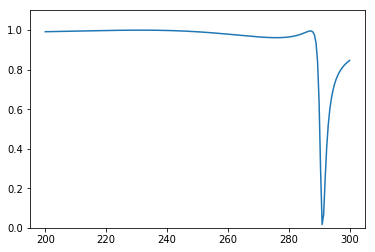

Test 73
True shape: [0.2        0.2        0.1        0.13169178 0.2        0.2       ]
Predicted shape: [[0.14303964 0.14855471 0.17701036 0.15653417 0.16139431 0.1862274 ]]



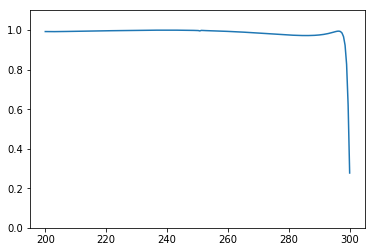

Test 74
True shape: [0.4 0.3 0.2 0.1 0.2 0.1]
Predicted shape: [[0.41101286 0.296113   0.18869996 0.14808652 0.10179291 0.09179309]]



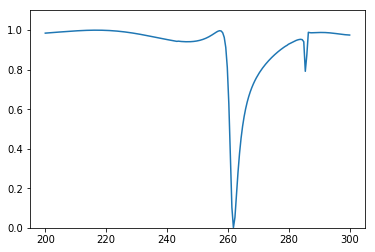

Test 75
True shape: [0.3        0.2        0.2        0.1        0.1        0.09876883]
Predicted shape: [[0.27176452 0.19299448 0.17016563 0.1326172  0.12053368 0.12648453]]



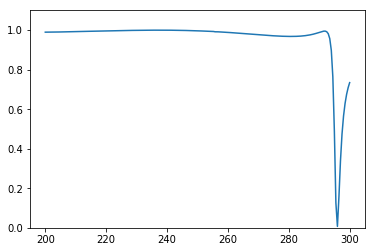

Test 76
True shape: [0.1        0.2        0.2        0.19753767 0.2        0.1       ]
Predicted shape: [[0.10826167 0.11802065 0.22073972 0.19567424 0.20423225 0.21166416]]



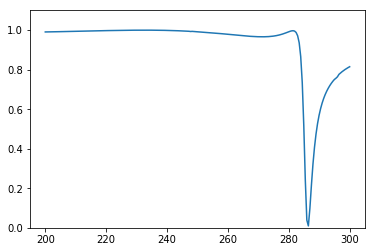

Test 77
True shape: [0.2        0.2        0.19753767 0.2        0.1        0.2       ]
Predicted shape: [[0.17523018 0.19643521 0.19993499 0.1859208  0.14493217 0.14895669]]



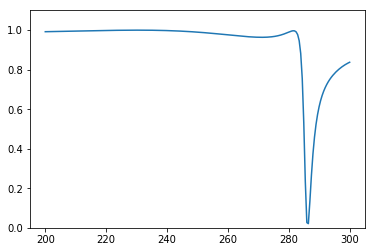

Test 78
True shape: [0.1        0.11044282 0.12680754 0.15329674 0.2        0.3       ]
Predicted shape: [[0.1438261  0.17216173 0.17333806 0.15688434 0.15179452 0.18066928]]



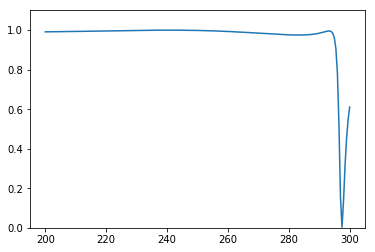

Test 79
True shape: [0.1        0.2        0.19753767 0.2        0.2        0.19753767]
Predicted shape: [[0.10018939 0.2015695  0.20267898 0.20130885 0.20697482 0.20353182]]



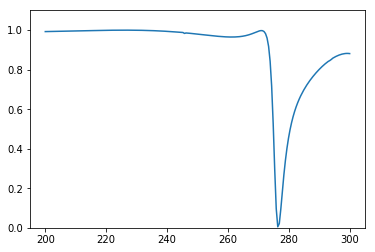

Test 80
True shape: [0.3        0.2        0.13169178 0.1        0.1        0.2       ]
Predicted shape: [[0.16893542 0.1431734  0.15337819 0.17158741 0.19024596 0.14640251]]



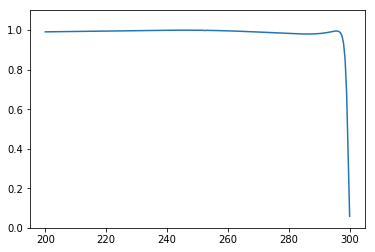

Test 81
True shape: [0.2 0.2 0.1 0.2 0.3 0.2]
Predicted shape: [[0.22454652 0.19660288 0.1337933  0.21701273 0.23091687 0.24509133]]



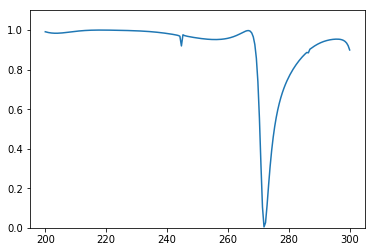

Test 82
True shape: [0.4 0.3 0.2 0.2 0.2 0.1]
Predicted shape: [[0.39910477 0.29339525 0.23941588 0.20687824 0.11144375 0.19184263]]



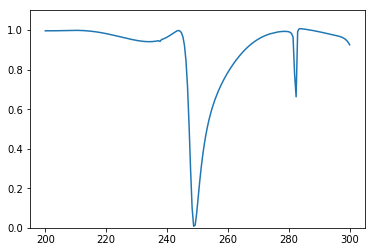

Test 83
True shape: [0.1        0.1        0.13169178 0.2        0.2        0.19753767]
Predicted shape: [[0.14468321 0.14395812 0.17211187 0.15505946 0.16804244 0.18066035]]



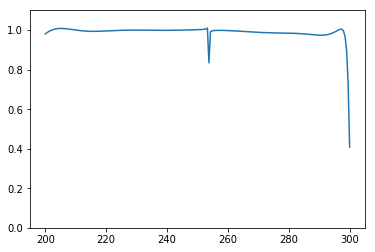

Test 84
True shape: [0.1        0.13169178 0.2        0.2        0.2        0.3       ]
Predicted shape: [[0.10432842 0.17166102 0.1854425  0.20895562 0.2119315  0.24141802]]



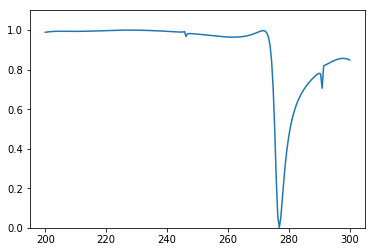

Test 85
True shape: [0.2        0.1        0.13169178 0.2        0.2370452  0.3       ]
Predicted shape: [[0.20484671 0.12773737 0.11932811 0.21282032 0.31132278 0.2204021 ]]



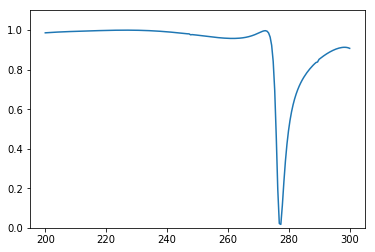

Test 86
True shape: [0.2       0.1       0.1       0.2       0.2370452 0.3      ]
Predicted shape: [[0.26985878 0.19680434 0.14881065 0.13452709 0.22249351 0.3174758 ]]



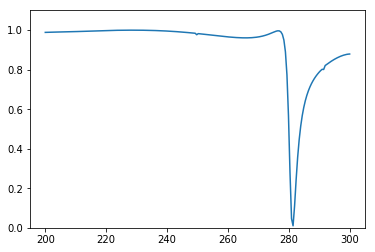

Test 87
True shape: [0.2        0.19753767 0.2        0.1        0.2        0.1       ]
Predicted shape: [[0.20387244 0.16588214 0.13239849 0.11520091 0.20984335 0.25172016]]



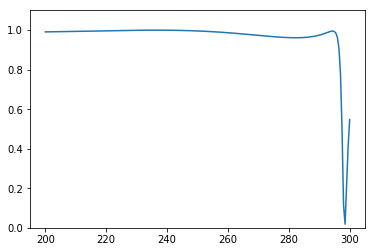

Test 88
True shape: [0.3      0.292613 0.292613 0.3      0.2      0.2     ]
Predicted shape: [[0.2757694  0.2822044  0.30861577 0.25353372 0.26894066 0.21584927]]



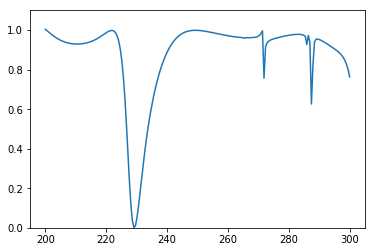

Test 89
True shape: [0.09876883 0.1        0.2        0.2        0.3        0.2       ]
Predicted shape: [[0.10418925 0.10362953 0.210013   0.20387158 0.28120777 0.26475263]]



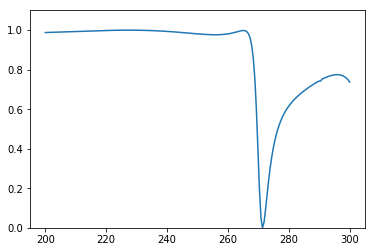

Test 90
True shape: [0.2        0.1        0.13169178 0.2        0.19753767 0.2       ]
Predicted shape: [[0.23870596 0.14956906 0.15838835 0.1511949  0.14133963 0.15835015]]



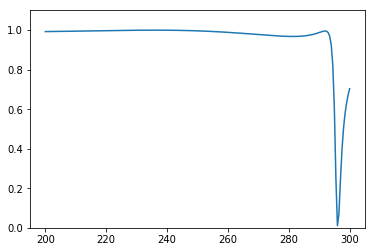

Test 91
True shape: [0.3        0.2        0.2        0.1        0.09876883 0.1       ]
Predicted shape: [[0.26770633 0.18821636 0.17132145 0.13234761 0.12108195 0.1293947 ]]



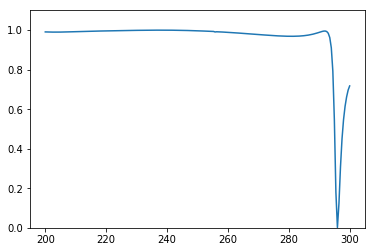

Test 92
True shape: [0.3        0.2        0.13169178 0.1        0.2        0.19753767]
Predicted shape: [[0.24817699 0.2016153  0.14306265 0.08495769 0.20840457 0.27691427]]



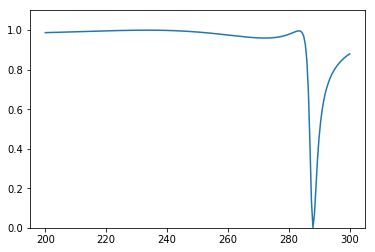

In [18]:
predicted = []
x = np.genfromtxt('meep_code/data/SP_xaxis.txt')
for i in range(len(test_X)):
    print('Test '+str(i))
    print('True shape: ' + str(test_Y[i]))
    print('Predicted shape: ' + str(model.predict(np.reshape(test_X[i], (1, 200))))+'\n')
    plt.ylim(0, 1.1)
    plt.plot(x, np.subtract(test_X[i], -0.5))
    plt.show()
    predicted.append(*model.predict(np.reshape(test_X[i], (1, 200))))

In [21]:
model.save('DFNN_O')

In [20]:
np.savetxt('prediction_dfnn.txt', predicted)

Train on 119 samples, validate on 30 samples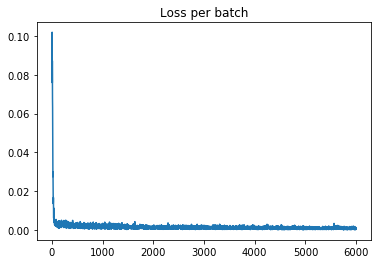